## Set up

In [17]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /home/facosta/pirnns/pirnns
Directory added to path:  /home/facosta/pirnns
Directory added to path:  /home/facosta/pirnns/pirnns


## Evaluate OOD trajectory length generalization for a single model

In [18]:
from pirnns.analysis.load_models import load_experiment_sweep
import torch

sweep_dir = (
    "/home/facosta/pirnns/pirnns/logs/experiments/timescales_sweep_20251002_064332"
)

# sweep_dir = "/home/facosta/pirnns/pirnns/logs/experiments/batch_sweep_20251004_000019"

# sweep_dir = "/home/facosta/pirnns/pirnns/logs/experiments/single_timescales_sweep_20251005_094501"

device = "cuda" if torch.cuda.is_available() else "cpu"

models, metadata, summary = load_experiment_sweep(
    sweep_dir=sweep_dir,
    device=device,
    use_lightning_checkpoint=True,
    checkpoint_type="best",
)

Loading 6 experiments with 4 seeds each...
Total models to load: 24
Using Lightning checkpoints

Loading experiment: discrete_single_05
  ✓ Loaded discrete_single_05/seed_0
  ✓ Loaded discrete_single_05/seed_1
  ✓ Loaded discrete_single_05/seed_2
  ✓ Loaded discrete_single_05/seed_3
Loading experiment: discrete_single_075
  ✓ Loaded discrete_single_075/seed_0
  ✓ Loaded discrete_single_075/seed_1
  ✓ Loaded discrete_single_075/seed_2
  ✓ Loaded discrete_single_075/seed_3
Loading experiment: discrete_single_1
  ✓ Loaded discrete_single_1/seed_0
  ✓ Loaded discrete_single_1/seed_1
  ✓ Loaded discrete_single_1/seed_2
  ✓ Loaded discrete_single_1/seed_3
Loading experiment: discrete_two
  ✓ Loaded discrete_two/seed_0
  ✓ Loaded discrete_two/seed_1
  ✓ Loaded discrete_two/seed_2
  ✓ Loaded discrete_two/seed_3
Loading experiment: discrete_four
  ✓ Loaded discrete_four/seed_0
  ✓ Loaded discrete_four/seed_1
  ✓ Loaded discrete_four/seed_2
  ✓ Loaded discrete_four/seed_3
Loading experiment: con

### Load Position Decoding Measurement

In [19]:
from pirnns.analysis.measurements import PositionDecodingMeasurement

measurement = PositionDecodingMeasurement(decode_k=3)

### Load OOD Trajectory Length Analysis

In [20]:
from pirnns.analysis.analyses import OODAnalysis

config = models["discrete_single_05"][0]["config"]

place_cell_centers = models["discrete_single_05"][0]["place_cell_centers"]

analysis = OODAnalysis(
    config,
    test_lengths=[20, 25, 50, 100],
    place_cell_centers=place_cell_centers,
)

model = models["discrete_single_05"][0]["model"]
analysis.run(model, measurement)

AnalysisResult(test_conditions=[20, 25, 50, 100], measurements=[0.07930046081542969, 0.082573046875, 0.10186995849609375, 0.13982696533203126], condition_name='trajectory_length', metadata={'training_length': 20, 'num_test_trajectories': 100})

## Evaluate OOD trajectory length generalization across a sweep (different models, multiple seeds)

### Use SweepEvaluator to apply OODAnalysis to all models in the sweep

In [21]:
from pirnns.analysis.sweep_evaluator import SweepEvaluator
from pirnns.analysis.analyses import OODAnalysis
from pirnns.analysis.measurements import PositionDecodingMeasurement

evaluator = SweepEvaluator(
    analysis_class=OODAnalysis,
    analysis_params={
        "test_lengths": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200],
        "num_test_trajectories": 100,
    },
    measurement_class=PositionDecodingMeasurement,
    measurement_params={"decode_k": 3},
    verbose=True,
)


results = evaluator.evaluate(models)
evaluator.print_summary(results)

Evaluating 6 experiments
Analysis: OODAnalysis
Measurement: PositionDecodingMeasurement

Experiment: discrete_single_05
  Seeds: 4
  Processing seed 0...
    Results: [0.07285289001464844, 0.07671051025390625, 0.07468480428059895, 0.08088650512695313, 0.08651846923828126, 0.08833734130859375, 0.09649583217075892, 0.09704983520507812, 0.10021089680989584, 0.10100258178710937, 0.1365334228515625, 0.15441399739583334, 0.2201664794921875]
  Processing seed 1...
    Results: [0.06975857543945313, 0.07354408264160156, 0.0792094217936198, 0.081670166015625, 0.084361181640625, 0.08868144734700521, 0.09715927559988839, 0.09501811218261719, 0.1003154296875, 0.1044631103515625, 0.1352956787109375, 0.14314521484375, 0.19793125]
  Processing seed 2...
    Results: [0.07170691680908203, 0.07208584594726562, 0.08010808817545573, 0.07841612243652343, 0.08937976684570313, 0.08408853149414063, 0.09024158586774554, 0.09878948974609375, 0.09763563368055556, 0.09754932250976563, 0.13858800048828124, 0.1657

In [22]:
results.experiment_results

{'discrete_single_05': ExperimentResult(experiment_name='discrete_single_05', test_conditions=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200], condition_name='trajectory_length', seed_results={0: [0.07285289001464844, 0.07671051025390625, 0.07468480428059895, 0.08088650512695313, 0.08651846923828126, 0.08833734130859375, 0.09649583217075892, 0.09704983520507812, 0.10021089680989584, 0.10100258178710937, 0.1365334228515625, 0.15441399739583334, 0.2201664794921875], 1: [0.06975857543945313, 0.07354408264160156, 0.0792094217936198, 0.081670166015625, 0.084361181640625, 0.08868144734700521, 0.09715927559988839, 0.09501811218261719, 0.1003154296875, 0.1044631103515625, 0.1352956787109375, 0.14314521484375, 0.19793125], 2: [0.07170691680908203, 0.07208584594726562, 0.08010808817545573, 0.07841612243652343, 0.08937976684570313, 0.08408853149414063, 0.09024158586774554, 0.09878948974609375, 0.09763563368055556, 0.09754932250976563, 0.13858800048828124, 0.165704638671875, 0.1773360839843

### Plot results

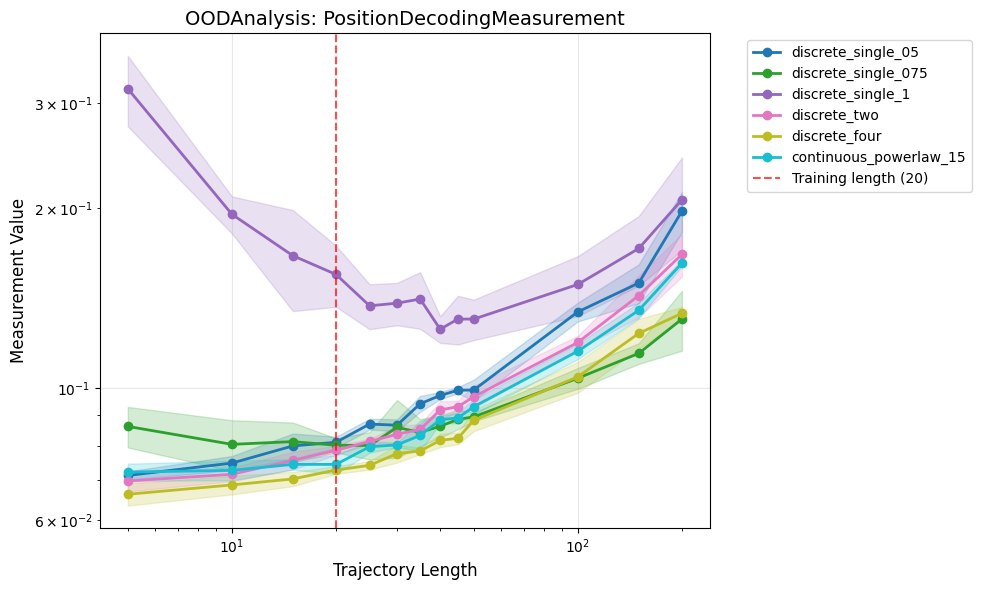

In [23]:
from pirnns.analysis.plotting import (
    plot_sweep_results,
)


plot_sweep_results(results, log_x=True, log_y=True)